<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [ ]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

In [3]:
data = df_86400
data = data.set_index("timestamp")
#data.head()

In [4]:
origin = "2023-06-02"
start = "2023-06-25" # origin + prediction_lenght
end = "2023-07-01"

train_data = data["2022-12-20":"2023-06-01"]
valid_data = data[origin:end]
test_data = data["2023-07-02":]

#### Scaling

In [5]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [66]:
batch_size = 32
num_features = 12
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 12
epochs = 10

# Models

## Forecasting one-step-ahead

In [67]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [68]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']

In [69]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

In [75]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0031 - mae: 0.0581 - val_loss: 0.0027 - val_mae: 0.0636
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028 - mae: 0.0583 - val_loss: 0.0021 - val_mae: 0.0559
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0029 - mae: 0.0571 - val_loss: 0.0017 - val_mae: 0.0487
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - mae: 0.0513 - val_loss: 0.0014 - val_mae: 0.0429
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027 - mae: 0.0542 - val_loss: 0.0013 - val_mae: 0.0399
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0023 - mae: 0.0512 - val_loss: 0.0013 - val_mae: 0.0390
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 - mae: 0.0560 - val_loss: 0.0013 - val_mae: 0.0389
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0025 - mae: 0.0529 - val_loss: 0.0013 - val_mae: 0.0396
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0024 - mae: 0.0530 - 

38853.719830513

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [118]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [119]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0025 - mae: 0.0519 - val_loss: 5.5399e-04 - val_mae: 0.0271
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - mae: 0.0462 - val_loss: 5.3751e-04 - val_mae: 0.0260
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - mae: 0.0401 - val_loss: 0.0013 - val_mae: 0.0404
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - mae: 0.0398 - val_loss: 5.4711e-04 - val_mae: 0.0260
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - mae: 0.0396 - val_loss: 5.6627e-04 - val_mae: 0.0261
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - mae: 0.0375 - val_loss: 8.8591e-04 - val_mae: 0.0321
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - mae: 0.0359 - val_loss: 6.4716e-04 - val_mae: 0.0270
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - mae: 0.0410 - val_loss: 5.4082e-04 - val_mae: 0.0258
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - l

25780.45427799225

#### Deep RNN

In [92]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.1059 - mae: 0.3484 - val_loss: 0.0111 - val_mae: 0.1383
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0067 - mae: 0.0981 - val_loss: 0.0077 - val_mae: 0.1178
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - mae: 0.0900 - val_loss: 0.0072 - val_mae: 0.1142
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0048 - mae: 0.0821 - val_loss: 0.0018 - val_mae: 0.0548
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - mae: 0.0632 - val_loss: 0.0015 - val_mae: 0.0448
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - mae: 0.0401 - val_loss: 5.5983e-04 - val_mae: 0.0244
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - mae: 0.0390 - val_loss: 5.5228e-04 - val_mae: 0.0242
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - mae: 0.0355 - val_loss: 8.6626e-04 - val_mae: 0.0304
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010 - m

24231.182411313057

### Multivariate Series

In [120]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [102]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.1421 - mae: 0.4423 - val_loss: 0.0806 - val_mae: 0.3365
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0963 - mae: 0.3501 - val_loss: 0.0386 - val_mae: 0.2175
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0486 - mae: 0.2539 - val_loss: 0.0307 - val_mae: 0.2138
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0420 - mae: 0.2257 - val_loss: 0.0268 - val_mae: 0.1953
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0271 - mae: 0.1840 - val_loss: 0.0230 - val_mae: 0.1783
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0209 - mae: 0.1605 - val_loss: 0.0198 - val_mae: 0.1653
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0147 - mae: 0.1387 - val_loss: 0.0181 - val_mae: 0.1571
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - mae: 0.1317 - val_loss: 0.0170 - val_mae: 0.1510
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0105 - mae: 0.1184 -

140337.735414505

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


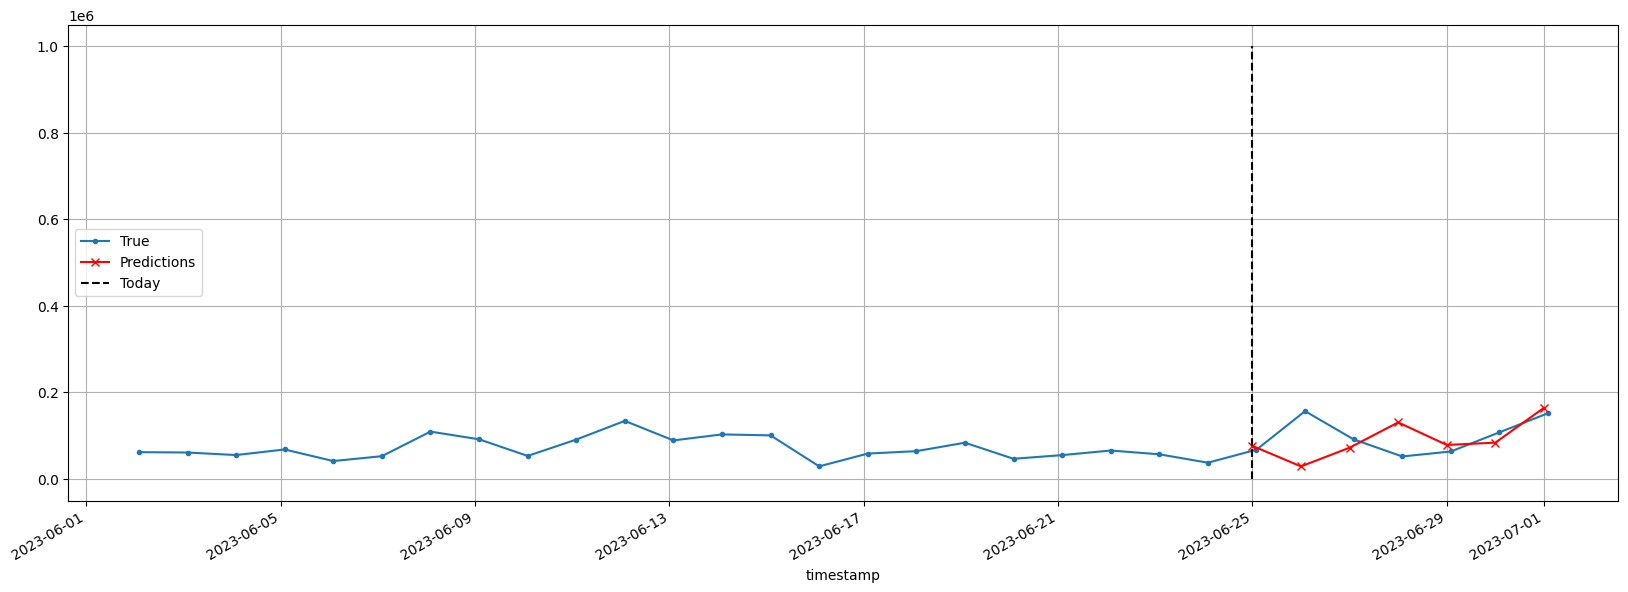

In [121]:
X = vl.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [122]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [158]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [167]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.2854 - mae: 0.5894 - val_loss: 0.2433 - val_mae: 0.5869
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2952 - mae: 0.6053 - val_loss: 0.2427 - val_mae: 0.5857
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2892 - mae: 0.5952 - val_loss: 0.2430 - val_mae: 0.5850
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2890 - mae: 0.5932 - val_loss: 0.2434 - val_mae: 0.5856
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2851 - mae: 0.5882 - val_loss: 0.2420 - val_mae: 0.5827
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2836 - mae: 0.5893 - val_loss: 0.2411 - val_mae: 0.5806
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2851 - mae: 0.5863 - val_loss: 0.2421 - val_mae: 0.5831
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2998 - mae: 0.6041 - val_loss: 0.2438 - val_mae: 0.5868
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2506 - mae: 0.5486 - 

580611.526966095

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


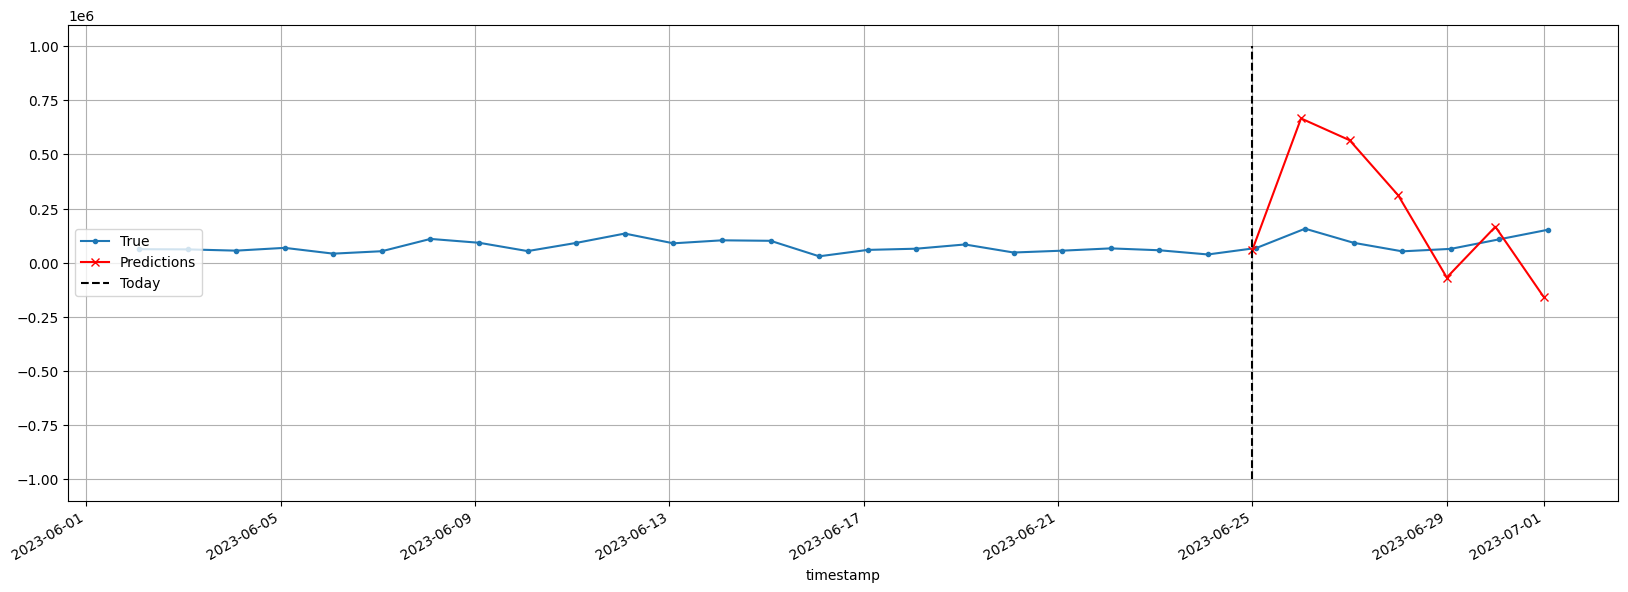

In [168]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X) # shape [1, 14]
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [161]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [162]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [171]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [172]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
      1/Unknown 2s 2s/step - loss: 0.4888 - mae: 0.8700

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.5202 - mae: 0.9025 - val_loss: 0.3540 - val_mae: 0.7261
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5216 - mae: 0.9028 - val_loss: 0.3381 - val_mae: 0.7073
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5113 - mae: 0.8901 - val_loss: 0.3207 - val_mae: 0.6868
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4645 - mae: 0.8345 - val_loss: 0.3052 - val_mae: 0.6684
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4551 - mae: 0.8225 - val_loss: 0.2930 - val_mae: 0.6533
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4432 - mae: 0.8075 - val_loss: 0.2835 - val_mae: 0.6417
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4173 - mae: 0.7709 - val_loss: 0.2762 - val_mae: 0.6336
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4096 - mae: 0.7626 - val_loss: 0.2706 - val_mae: 0.6278
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4168 - mae: 0.7696 - val_loss: 

623794.0788269043

Perchè sembra migliorare? dovrebbe peggiorare (?)

In [173]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=valid.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - valid["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
MAE for +1: 414,898
MAE for +2: 150,662
MAE for +3: 375,596
MAE for +4: 236,956
MAE for +5: 237,687
MAE for +6: 189,477
MAE for +7: 381,436


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


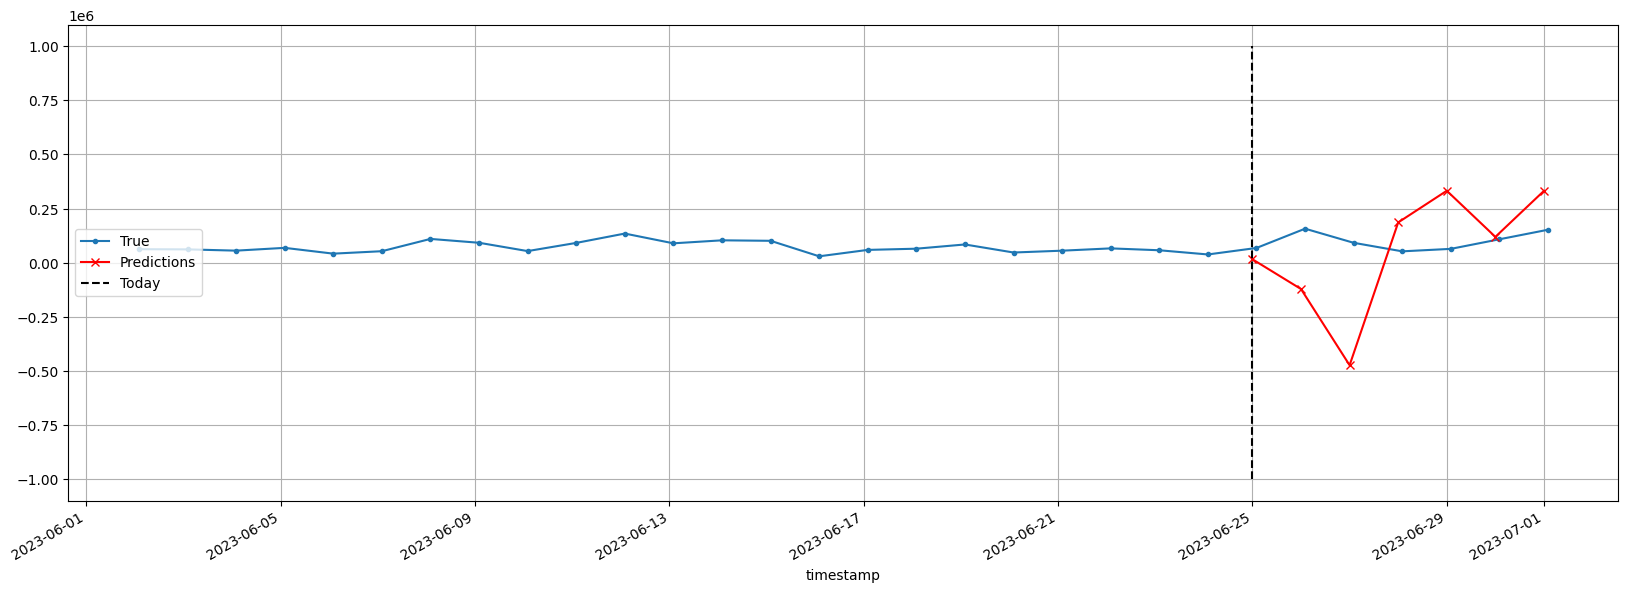

In [174]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [175]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [176]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [180]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
      1/Unknown 2s 2s/step - loss: 0.3620 - mae: 0.6739

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.3470 - mae: 0.6654 - val_loss: 0.2696 - val_mae: 0.6220
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3440 - mae: 0.6635 - val_loss: 0.2680 - val_mae: 0.6200
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3240 - mae: 0.6404 - val_loss: 0.2657 - val_mae: 0.6176
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3382 - mae: 0.6549 - val_loss: 0.2637 - val_mae: 0.6157
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3157 - mae: 0.6262 - val_loss: 0.2618 - val_mae: 0.6140
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3278 - mae: 0.6399 - val_loss: 0.2611 - val_mae: 0.6143
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3390 - mae: 0.6553 - val_loss: 0.2608 - val_mae: 0.6159
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3471 - mae: 0.6649 - val_loss: 0.2598 - val_mae: 0.6150
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3333 - mae: 0.6496 - val_loss: 

610864.1624450684

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


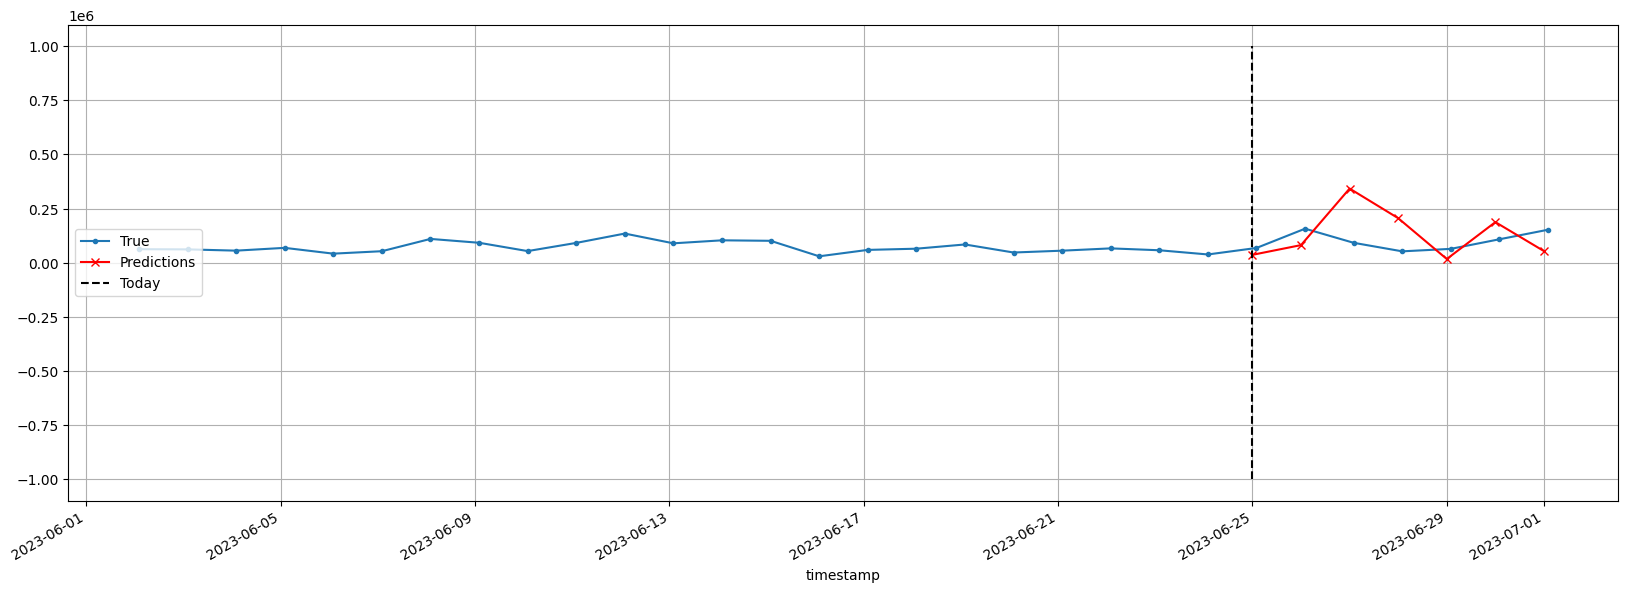

In [181]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [182]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [183]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

Epoch 1/10
      1/Unknown 3s 3s/step - loss: 0.4377 - mae: 0.8037

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.3981 - mae: 0.7613 - val_loss: 0.2593 - val_mae: 0.6610
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4060 - mae: 0.7703 - val_loss: 0.2558 - val_mae: 0.6554
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3681 - mae: 0.7271 - val_loss: 0.2514 - val_mae: 0.6486
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3917 - mae: 0.7482 - val_loss: 0.2473 - val_mae: 0.6421
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3544 - mae: 0.7059 - val_loss: 0.2436 - val_mae: 0.6360
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3369 - mae: 0.6803 - val_loss: 0.2402 - val_mae: 0.6301
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3645 - mae: 0.7142 - val_loss: 0.2374 - val_mae: 0.6251
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3488 - mae: 0.6906 - val_loss: 0.2347 - val_mae: 0.6202
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3403 - mae: 0.6820 - val_loss: 

611909.806728363

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


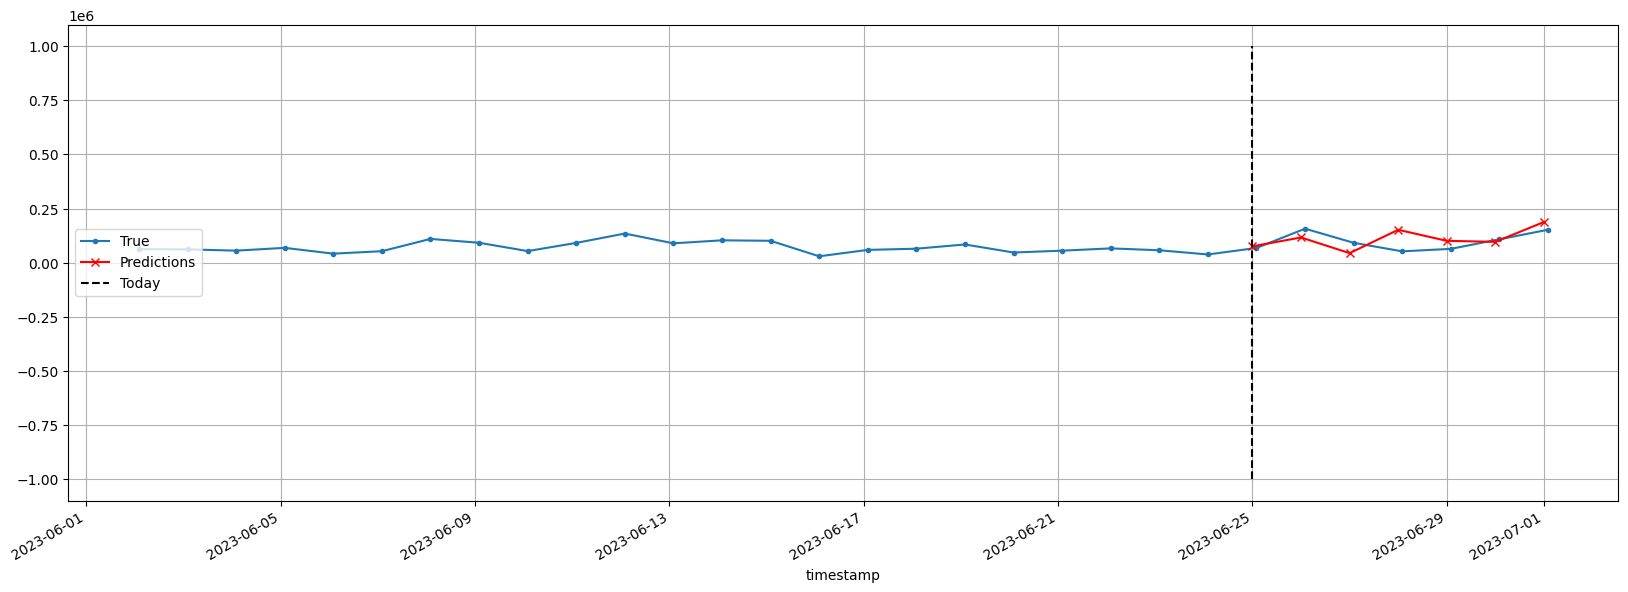

In [184]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [185]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [186]:
fit_and_evaluate(gru, seq2seq_train, seq2seq_valid)

Epoch 1/10
      1/Unknown 3s 3s/step - loss: 0.3641 - mae: 0.7063

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.4096 - mae: 0.7655 - val_loss: 0.2827 - val_mae: 0.6765
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4104 - mae: 0.7683 - val_loss: 0.2735 - val_mae: 0.6650
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4106 - mae: 0.7647 - val_loss: 0.2636 - val_mae: 0.6519
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4181 - mae: 0.7737 - val_loss: 0.2550 - val_mae: 0.6410
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3935 - mae: 0.7384 - val_loss: 0.2470 - val_mae: 0.6291
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3716 - mae: 0.7167 - val_loss: 0.2405 - val_mae: 0.6191
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4042 - mae: 0.7454 - val_loss: 0.2357 - val_mae: 0.6108
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3636 - mae: 0.6963 - val_loss: 0.2319 - val_mae: 0.6030
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3634 - mae: 0.6946 - val_loss: 

590473.2346534729

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


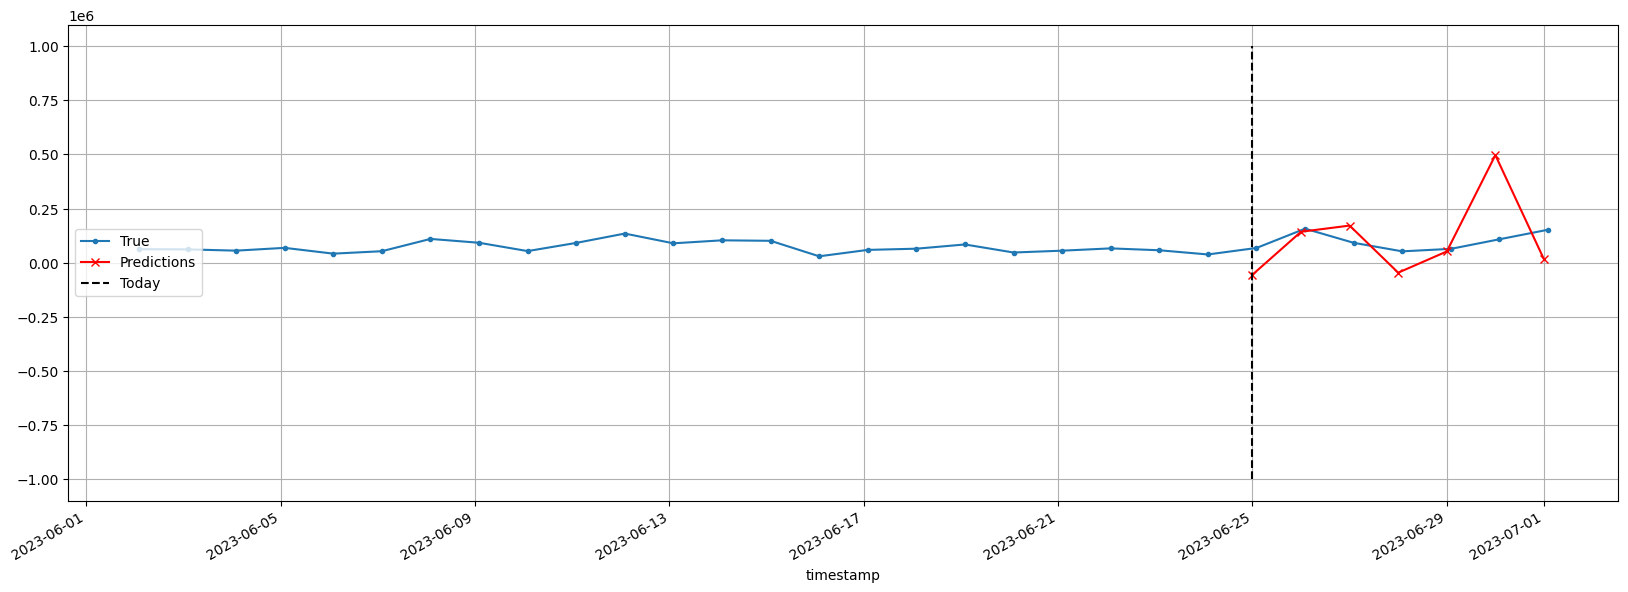

In [187]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [191]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [192]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
      1/Unknown 2s 2s/step - loss: 0.3935 - mae: 0.7521

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.4319 - mae: 0.7948 - val_loss: 0.3436 - val_mae: 0.7152
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4471 - mae: 0.8082 - val_loss: 0.3284 - val_mae: 0.6987
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.4026 - mae: 0.7572 - val_loss: 0.3124 - val_mae: 0.6806
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3828 - mae: 0.7323 - val_loss: 0.2987 - val_mae: 0.6643
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3879 - mae: 0.7336 - val_loss: 0.2882 - val_mae: 0.6511
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3707 - mae: 0.7121 - val_loss: 0.2810 - val_mae: 0.6412
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3860 - mae: 0.7254 - val_loss: 0.2755 - val_mae: 0.6328
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3463 - mae: 0.6775 - val_loss: 0.2706 - val_mae: 0.6256
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3816 - mae: 0.7147 - val_loss: 

618432.6410293579

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


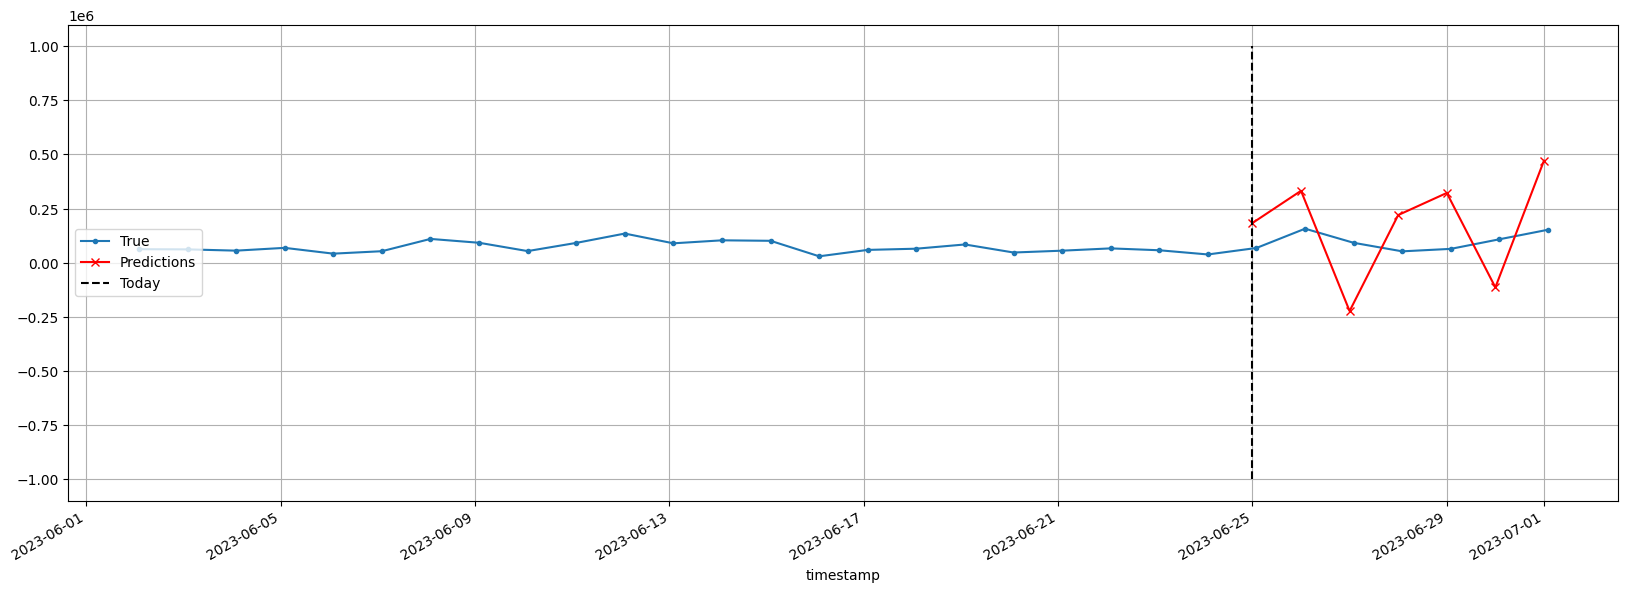

In [193]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [201]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [202]:
longer_train = to_seq2seq_dataset(train, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght*2)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [203]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid)

Epoch 1/10
      1/Unknown 3s 3s/step - loss: 0.2697 - mae: 0.6243

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.3254 - mae: 0.6850 - val_loss: 0.2741 - val_mae: 0.6615
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3282 - mae: 0.6837 - val_loss: 0.2715 - val_mae: 0.6564
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3202 - mae: 0.6702 - val_loss: 0.2684 - val_mae: 0.6498
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3182 - mae: 0.6676 - val_loss: 0.2656 - val_mae: 0.6430
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3505 - mae: 0.6946 - val_loss: 0.2631 - val_mae: 0.6366
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2981 - mae: 0.6337 - val_loss: 0.2611 - val_mae: 0.6309
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2949 - mae: 0.6231 - val_loss: 0.2595 - val_mae: 0.6259
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3284 - mae: 0.6603 - val_loss: 0.2585 - val_mae: 0.6224
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2859 - mae: 0.6067 - val_loss: 

616771.2807655334

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


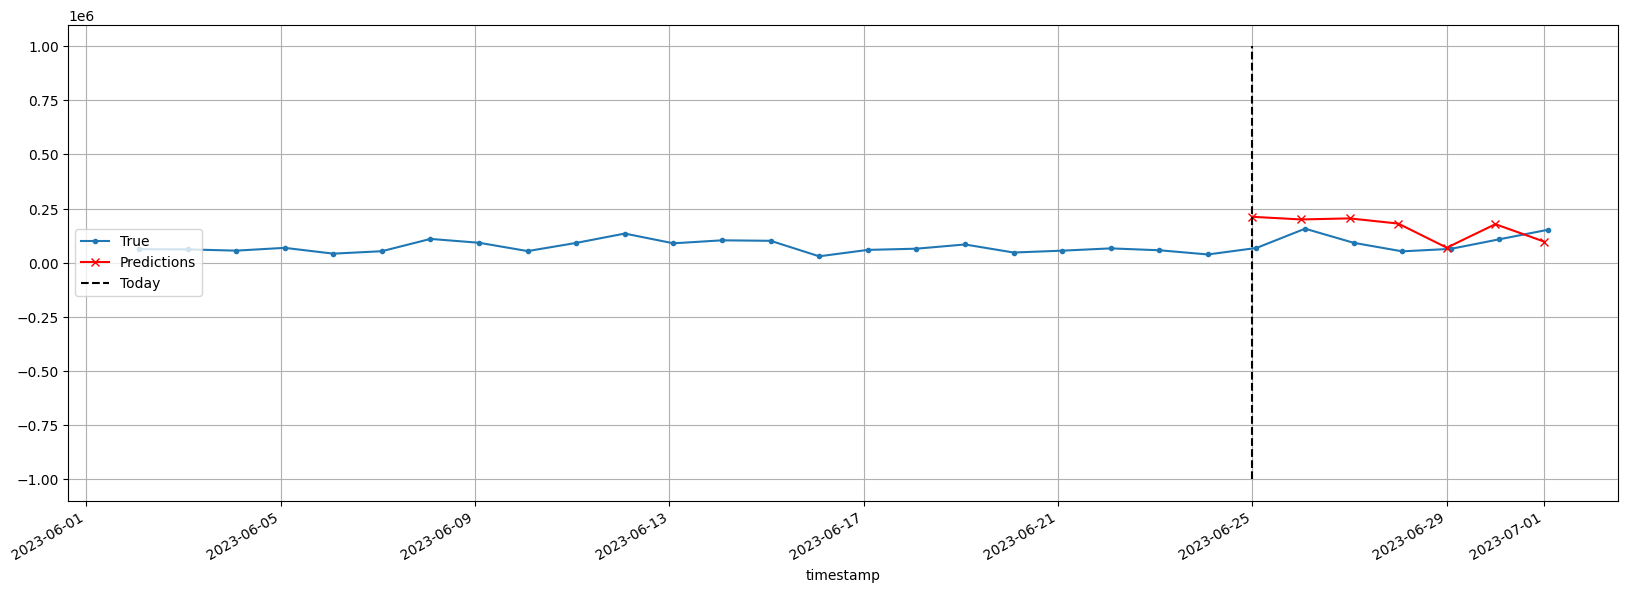

In [204]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()